In [1]:
!pip install deap


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install  PyWavelets 


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import glob
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, concatenate
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# Paths to the dataset folders
train_path = "/Users/niteshyadav/Lyme_Disease/train"
test_path = "/Users/niteshyadav/Lyme_Disease/test"
val_path = "/Users/niteshyadav/Lyme_Disease/val"

# Genetic algorithm-based region of interest extraction
def genetic_roi_extraction(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to find the ROI
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours and filter based on circularity
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    
    # Create mask for the largest contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [max_contour], -1, 255, thickness=cv2.FILLED)
    
    # Apply mask to the original image
    roi = cv2.bitwise_and(image, image, mask=mask)
    return roi

# Function to extract LBP features
def extract_lbp_features(image):
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype('float')
    hist /= hist.sum()
    return hist

# Load pre-trained CNN model (VGG16 in this case)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
cnn_model = Model(inputs=base_model.input, outputs=x)

# Example function to preprocess image for VGG16
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalize image
    return image

# Helper function to load images and extract features
def load_and_extract_features(path):
    lbp_features_list = []
    cnn_features_list = []
    labels = []

    for label in ['Positive', 'Negative']:
        label_path = os.path.join(path, label)
        for file in glob.glob(os.path.join(label_path, '*.jpg')):
            image = cv2.imread(file)
            if image is None:
                print(f"Failed to read image: {file}")
                continue
            
            # Segment image using genetic ROI extraction
            roi_image = genetic_roi_extraction(image)

            # Extract LBP features
            gray_roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
            lbp_features = extract_lbp_features(gray_roi_image)
            lbp_features_list.append(lbp_features)

            # Extract CNN features
            preprocessed_image = preprocess_image(file)
            cnn_features = cnn_model.predict(preprocessed_image)
            cnn_features_list.append(cnn_features.flatten())

            # Append label
            labels.append(1 if label == 'Positive' else 0)

    # Combine LBP and CNN features
    combined_features = np.hstack([cnn_features_list, lbp_features_list])
    return combined_features, np.array(labels)

# Load and extract features from the datasets
X_train, y_train = load_and_extract_features(train_path)
X_test, y_test = load_and_extract_features(test_path)
X_val, y_val = load_and_extract_features(val_path)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Encode labels
le = LabelEncoder()
y_train_resampled = le.fit_transform(y_train_resampled)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

# Define a dense neural network with regularization
def create_combined_model(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Combine LBP and CNN features for training
input_dim = X_train_resampled.shape[1]
model = create_combined_model(input_dim)

# Data augmentation for training dataset
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Training the model with augmented data
train_generator = datagen.flow(X_train_resampled, y_train_resampled, batch_size=32)
val_data = (X_val, y_val)

# Train the model
model.fit(train_generator, epochs=20, validation_data=val_data)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

# Visualize the graphs for a sample positive and negative image
def visualize_image(image, title):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

positive_image_path = glob.glob(os.path.join(train_path, 'Positive', '*.jpg'))[0]
negative_image_path = glob.glob(os.path.join(train_path, 'Negative', '*.jpg'))[0]

positive_image = cv2.imread(positive_image_path)
negative_image = cv2.imread(negative_image_path)

visualize_image(positive_image, 'Positive Image')
visualize_image(negative_image, 'Negative Image')


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 96ms/step


ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (6588, 25098))

1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 95ms/step
Epoch 1/20
1030/1030 [==============================] - 7s 6ms/step - loss: 0.7639 - accuracy: 0.5030 - val_loss: 0.7114 - val_accuracy: 0.1858
Epoch 2/20
1030/1030 [==============================] - 6s 5ms/step - loss: 0.7038 - accuracy: 0.4991 - val_loss: 0.6966 - val_accuracy: 0.8142
Epoch 3/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.6968 - accuracy: 0.4977 - val_loss: 0.6973 - val_accuracy: 0.1858
Epoch 4/20
1030/1030 [==============================] - 6s 5ms/step - loss: 0.6943 - accuracy: 0.4972 - val_loss: 0.6947 - val_accuracy: 0.1858
Epoch 5/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.6935 - accuracy: 0.4939 - val_loss: 0.6918 - val_accuracy: 0.8142
Epoch 6/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.7012 - val_accuracy: 0.1858
Epoch 7/20
1030/1030 [==============================] - 6s 5ms/step - loss: 0.6932 -

/Users/niteshyadav/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/niteshyadav/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/niteshyadav/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


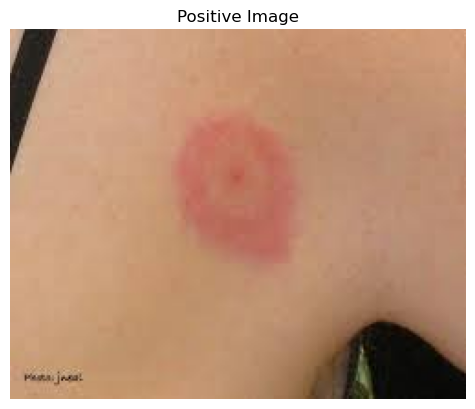

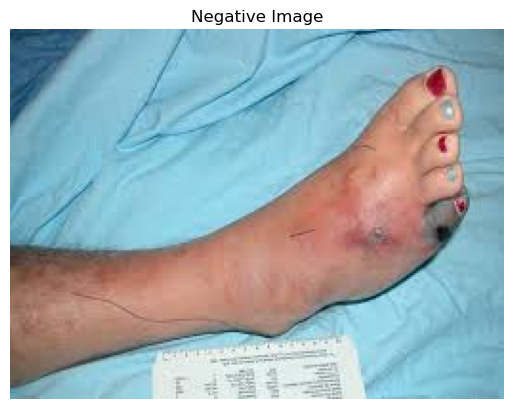

In [5]:
import os
import glob
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, concatenate
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

# Paths to the dataset folders
train_path = "/Users/niteshyadav/Lyme_Disease/train"
test_path = "/Users/niteshyadav/Lyme_Disease/test"
val_path = "/Users/niteshyadav/Lyme_Disease/val"

# Genetic algorithm-based region of interest extraction
def genetic_roi_extraction(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to find the ROI
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours and filter based on circularity
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    
    # Create mask for the largest contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [max_contour], -1, 255, thickness=cv2.FILLED)
    
    # Apply mask to the original image
    roi = cv2.bitwise_and(image, image, mask=mask)
    return roi

# Function to extract LBP features
def extract_lbp_features(image):
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype('float')
    hist /= hist.sum()
    return hist

# Load pre-trained CNN model (VGG16 in this case)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
cnn_model = Model(inputs=base_model.input, outputs=x)

# Example function to preprocess image for VGG16
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalize image
    return image

# Helper function to load images and extract features
def load_and_extract_features_from_images(image_list, labels_list):
    lbp_features_list = []
    cnn_features_list = []

    for image_path, label in zip(image_list, labels_list):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue
        
        # Segment image using genetic ROI extraction
        roi_image = genetic_roi_extraction(image)

        # Extract LBP features
        gray_roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
        lbp_features = extract_lbp_features(gray_roi_image)
        lbp_features_list.append(lbp_features)

        # Extract CNN features
        preprocessed_image = preprocess_image(image_path)
        cnn_features = cnn_model.predict(preprocessed_image)
        cnn_features_list.append(cnn_features.flatten())

    # Combine LBP and CNN features
    combined_features = np.hstack([cnn_features_list, lbp_features_list])
    return combined_features

# Function to prepare data for augmentation
def prepare_image_list_and_labels(path):
    image_list = []
    labels_list = []

    for label in ['Positive', 'Negative']:
        label_path = os.path.join(path, label)
        for file in glob.glob(os.path.join(label_path, '*.jpg')):
            image_list.append(file)
            labels_list.append(1 if label == 'Positive' else 0)

    return image_list, labels_list

# Prepare image list and labels
train_image_list, train_labels_list = prepare_image_list_and_labels(train_path)
test_image_list, test_labels_list = prepare_image_list_and_labels(test_path)
val_image_list, val_labels_list = prepare_image_list_and_labels(val_path)

# Data augmentation for training dataset
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Apply augmentation and extract features
def augment_and_extract_features(image_list, labels_list):
    augmented_features = []
    augmented_labels = []

    for image_path, label in zip(image_list, labels_list):
        image = load_img(image_path, target_size=(224, 224))
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)
        
        # Generate augmented images
        aug_iter = datagen.flow(image_array, batch_size=1)
        for _ in range(5):  # Generate 5 augmented images per original image
            aug_image = next(aug_iter)[0].astype('uint8')
            aug_image_path = 'temp_aug_image.jpg'
            cv2.imwrite(aug_image_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
            features = load_and_extract_features_from_images([aug_image_path], [label])
            augmented_features.append(features)
            augmented_labels.append(label)

    augmented_features = np.vstack(augmented_features)
    augmented_labels = np.array(augmented_labels)
    return augmented_features, augmented_labels

# Extract features from augmented images
X_train, y_train = augment_and_extract_features(train_image_list, train_labels_list)
X_test = load_and_extract_features_from_images(test_image_list, test_labels_list)
X_val = load_and_extract_features_from_images(val_image_list, val_labels_list)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Encode labels
le = LabelEncoder()
y_train_resampled = le.fit_transform(y_train_resampled)
y_test = le.transform(test_labels_list)
y_val = le.transform(val_labels_list)

# Define a dense neural network with regularization
def create_combined_model(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Combine LBP and CNN features for training
input_dim = X_train_resampled.shape[1]
model = create_combined_model(input_dim)

# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

# Visualize the graphs for a sample positive and negative image
def visualize_image(image, title):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

positive_image_path = glob.glob(os.path.join(train_path, 'Positive', '*.jpg'))[0]
negative_image_path = glob.glob(os.path.join(train_path, 'Negative', '*.jpg'))[0]

positive_image = cv2.imread(positive_image_path)
negative_image = cv2.imread(negative_image_path)

visualize_image(positive_image, 'Positive Image')
visualize_image(negative_image, 'Negative Image')
